# Cartpole, again

In [1]:
import numpy as np
import torch
import random
import time
from tqdm import tqdm
from copy import deepcopy
import gym
from gym import spaces
import matplotlib.pyplot as plt

# Task

In [2]:
env = gym.make('CartPole-v0')

In [3]:
env = gym.make('LunarLander-v2')

In [4]:
class GridWorld(gym.Env):
    
    def __init__(self, n, goal=None, holes=None):
        '''
         env = GridWorld(n, goal, holes=None)
         
         Creates a 2D GridWorld environment of size (n,n).
         
         Coors are (row,col).
         Actions are indexed 0-3
              2
            3 + 1
              0
         goal is a list of tuples for the goal state ([row,col], r)
        '''
        super().__init__()
        self.n = n
        n_actions = 4
        self.P = np.array([[1,0],[0,1],[-1,0],[0,-1]], dtype=int)
        self.action_space = spaces.Discrete(n_actions)
        self.observation_space = spaces.MultiDiscrete((self.n,self.n))
        self.terminal = []
        self.R = np.zeros((self.n, self.n))
        if goal is not None:
            for g in goal:
                self.terminal.append(self.c2i(g[0]))
                self.R[g[0][0], g[0][1]] = g[1]
        else:
            self.terminal.append(self.c2i([3,4]))
            self.R[3, 4] = 10.
        self.coords = self.sample_input()
        
    def sample_input(self):
        return self.observation_space.sample()
    
    def seed(self, seed_val):
        super().seed(seed_val)
        
    def reset(self):
        self.coords = self.sample_input()
        return self.coords
    
    def state(self):
        return self.coords
    
    def step(self, action):
        s = self.coords + self.P[action,:]  # Proposed next state
        # Is it a valid state? What is the reward?
        if s[0]<0 or s[0]>=self.n:
            reward = -4.
            s[0] = np.clip(s[0], 0, self.n-1)
        elif s[1]<0 or s[1]>=self.n:
            reward = -4.
            s[1] = np.clip(s[1], 0, self.n-1)
        else:
            self.coords = s
            reward = self.R[tuple(self.coords)]
        done = self.c2i(self.coords) in self.terminal
        return self.coords, reward, done, {}
    
    def c2i(self, coords):
        return coords[0]*self.n + coords[1]
    def i2c(self, idx):
        row = idx//self.n
        col = idx%self.n
        return np.array([row,col])
    
    def flatten(self, x):
        return np.reshape(x, (self.n**2, x.shape[-1]))
    def unflatten(self, x):
        return np.reshape(x, (self.n, self.n, x.shape[-1]))
    
    def __str__(self):
        blah = f'Location: {self.coords}'
        return blah
    def __repr__(self):
        return self.__str__()
        
    def showR(self):
        print(np.flipud(self.R.T))
        
    def draw(self, traj=None, fig=None):
        '''
         fig = env.Draw(traj=None, fig=None)
         
         Draws the arena, along with a single trajectory(optional).
         traj is a list of dictionaries, where each element is:
           dict(a=<action>, s=<state>, sp=<next state>, r=<reward>)
        '''
        tcoords = []
        if traj is not None:
            #tcoords.append(traj[0]['s'])
            for t in traj:
                tcoords.append(t['s'])
                if t['d']:
                    break
            tcoords.append(traj[-1]['sp'])
            tcoords = np.array(tcoords)
        if fig is None:
            fig = plt.figure(figsize=(8,8))
        for row in range(self.n):
            for col in range(self.n):
                r = self.R[row,col]
                if r>0:
                    plt.plot(col, row, 'yo', markersize=r)
                elif r<0:
                    plt.plot(col, row, 'ko', markersize=-r)
        if traj is not None:
            plt.plot(tcoords[:,1], tcoords[:,0], 'o--')
        plt.grid(True)
        #plt.plot(traj[0]['s'][0], traj[0]['s'][1], 'go')
        plt.plot(tcoords[0,1], tcoords[0,0], 'go')
        plt.plot(tcoords[-1,1], tcoords[-1,0], 'ro')
        #plt.axis('image')
        plt.axis([-1,self.n,self.n,-1])
        return fig

## Vector_env

In [5]:
class Vector_env(gym.Wrapper):
    '''
     class Vector_env
     
     Acts as a wrapper for the OpenAI gym environments.
    '''
    def __init__(self, EnvConstructor, n=1):
        '''
         venv = Vector_env(env, n=1)
         
         Creates n copies of env.
        '''
        super().__init__(EnvConstructor())
        self.envs = []
        self.n_envs = n
        for k in range(n):
            env_r = EnvConstructor() #deepcopy(env)
            r = np.random.randint(10000)
            env_r.seed(r)
            self.envs.append(env_r)
        self.observation_space = self.envs[0].observation_space
        self.action_space = self.envs[0].action_space
    
    def reset(self):
        '''
         states = venv.reset()
         
         Resets all the environments, and returns an array with the
         reset states in each row.
        '''
        states = []
        for e in self.envs:
            state = e.reset()
            states.append(state)
        return np.array(states)
    
    def step(self, actions):
        '''
         S, R, done, info = venv.step(actions)
         
         Takes one step in each of the environments, and returns an array
         for each of the resulting outputs.
         
         Inputs:
           actions   an array of actions
           
         Outputs:
           S    array of states after the step
           R    array of rewards from the step
           done array of Boolean flags:
                  False means episode continues
                  True means episode is done
        '''
        S, R, dones = [], [], []
        for e,a in zip(self.envs, actions):
            next_s, r, done, inf = e.step(a)
            if done:
                S.append(e.reset())
            else:
                S.append(next_s)
            R.append(r)
            dones.append(done)
        return np.array(S), np.array(R), np.array(dones), {}
    
    def set_max_episode_steps(self, n):
        for env in self.envs:
            env._max_episode_steps = n
            
    def state(self):
        S = []
        for e in self.envs:
            S.append(e.state())
        return np.array(S)

# Agent

In [6]:
class ReplayBuffer():
    def __init__(self, size=1000000):
        self.memory = [] #deque(maxlen=size)
        
    def store(self, s, a, r, sp, d):
        for trans in zip(s,a,r,sp,d):
            self.memory.append(trans)
            #self.memory.append((s, a, r, sp, d))
    
    def sample(self, num=32):
        num = min(num, len(self.memory))
        blah = random.sample(self.memory, num)
        s,a,r,sp,d = zip(*blah)
        return np.array(s), np.array(a), np.array(r), np.array(sp), np.array(d)

In [12]:
env = GridWorld(5)

NameError: name 'GridWorld' is not defined

In [92]:
class Agent(object):
    '''
     class Agent(env)
     
     Represents an RL agent. Its Q function is represented by a neural network, so that
       agent.Q(s) returns a vector of probabilities over action-space.
       
     The input env is a sample of the environment that the agent will act in.
    '''
    def __init__(self, venv):
        '''
         ag = Agent(venv)
         
         Instantiates an Agent object.
         
         Inputs:
           venv  a Vector_env object, containing the environments for the task
        '''
        self.gamma = 0.99
        
        #***** USE THIS FOR GridWorld *****
        #self.state_shape = np.prod(venv.observation_space.nvec)
        
        #***** USE THIS FOR CartPole *****
        self.state_shape = venv.observation_space.shape[0]
        
        self.n_actions = venv.action_space.n  #n_actions
        
        self.venv = venv  # useful for accessing states, etc.
        
        # Q function: R^4 -> R^2 Q-value vector
        self.Q = torch.nn.Sequential(
                      torch.nn.Linear(self.state_shape, 128),
                      torch.nn.Tanh(),
                      torch.nn.Linear(128, 32),
                      torch.nn.Tanh(),
                      torch.nn.Linear(32, self.n_actions),
                      #torch.nn.LogSoftmax(dim=1),
                    )
        self.optim = torch.optim.Adam(self.Q.parameters(), lr=0.001)

    def process_inputs(self, s):
        return s   #***** FOR CartPole *****
        #***** BELOW FOR GridWorld one-hot *****
        blah = np.zeros((len(s), np.prod(self.venv.observation_space.nvec)))
        for k,ss in enumerate(s):
            q = int(self.venv.envs[0].c2i(ss))
            blah[k,q] = 1.
        return blah
    
    def choose_action(self, s, eps=0.):
        '''
         A = ag.choose_action(s, eps=0.)
         
         Choose an action, given the state s.
         With probability eps, it will choose an action randomly.
         Otherwise, it will choose an action that yields the highest Q-value.
        '''
        with torch.no_grad():
            Qvals = self.Q(torch.tensor(self.process_inputs(s), dtype=torch.float))
            a = torch.argmax(Qvals, dim=1).numpy()
        
        # epsilon-greedy
        bs = len(s)
        if eps>=1.e-8:
            a_random = np.random.choice(self.n_actions, size=(bs,))
            r = np.random.rand(bs)
            ridx = r<eps
            a[ridx] = a_random[ridx]
            
        return a
    
    def update(self, s, a, r, sp, d, alpha=0.01):
        '''
         env.update(s, a, r, sp, d, alpha=0.01)
         
         Learn from a bunch of transitions.
         This method updates the Q-function.
        '''
        loss_fcn = torch.nn.MSELoss()
                
        # Get estimate of current value
        Qs = self.Q(torch.tensor(self.process_inputs(s), dtype=torch.float))
        Qsa = Qs[range(len(Qs)),a]
        
        # Bellmann's equation to get a better estimate
        with torch.no_grad():
            Qsp = self.Q(torch.tensor(self.process_inputs(sp), dtype=torch.float))  # value for all actions
            maxQs = torch.amax(Qsp, dim=1)
            target = torch.tensor(r, dtype=torch.float) + self.gamma*(1-torch.as_tensor(d).float())*maxQs
            
        # Gradient descent of Q(S,A) -> r + gamma argmax_s Q(S',a)
        loss = loss_fcn(Qsa, target)
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        

# Helper functions

In [160]:
def train(agent, venv, buf, episodes=100, T=1000, batch_size=32, alpha=0.01, eps=0.):
    '''
     ag.train(agent, venv, buf, episodes=100, T=1000, batch_size=32, alpha=0.01, eps=0.)

     Trains the agent on the environ
    '''
    # First, let's populate a replay buffer
    #buf = ReplayBuffer(size=T*batch_size)
    for e in tqdm(range(episodes)):
        s = venv.reset()
        for k in range(T):
            a = agent.choose_action(s, eps=eps)
            sp, r, done, _ = venv.step(a)
            buf.store(s, a, r, sp, done)
            s = sp

            batch = buf.sample(batch_size)
            agent.update(batch[0], batch[1], batch[2], batch[3], batch[4])
            if all(done):
                break

In [185]:
def simulate(agent, trials=1, eps=0., eps_decay=0.995):
    time.sleep(1)
    avg_k = 0.
    for trial in range(trials):
        s = agent.venv.envs[0].reset()
        for k in range(2000):
            agent.venv.envs[0].render()
            a = agent.choose_action([s], eps=eps*eps_decay**k)

            sp, r, done, info = agent.venv.envs[0].step(a[0])
            s = sp
            if done:
                print('Done after '+str(k))
                avg_k += k
                break
                
    print('Average reward: '+str(avg_k/trials))
    time.sleep(1)
    agent.venv.envs[0].close()

In [157]:
def episode(agent, env, s=None, max_iters=100, eps=0.):
    done = False
    n_iters = 0
    if s is None:
        s = env.reset()
    else:
        env.coords = np.array(s)
    traj = []
    while not done and n_iters<max_iters:
        a = agent.choose_action([s], eps=eps)
        sp, r, done, _ = env.step(a[0])
        #print(s, a, r, sp, done)
        traj.append(dict(a=a[0], s=s, sp=sp, r=r, d=done))
        s = sp
        n_iters += 1
    print(n_iters, done)
    return traj

# Train and Test

## CartPole

In [480]:
venv = Vector_env((lambda : gym.make('CartPole-v0')), n=32)
ag = Agent(venv)

In [484]:
buf = train(ag, venv, T=10000, alpha=0.001, eps=0., batch_size=32)

100%|██████████| 10000/10000 [00:16<00:00, 611.04it/s]


In [485]:
simulate(ag, trials=3)

Done after 199
Done after 199
Done after 199
Average reward: 199.0


## MoonLander

In [259]:
venv = Vector_env((lambda : gym.make('LunarLander-v2')), n=1)
ag = Agent(venv)

In [260]:
buf = ReplayBuffer()

In [263]:
venv.set_max_episode_steps(1000)
epochs = 10
for epoch in range(epochs):
    eps = np.exp(-epoch/10)
    train(ag, venv, buf, episodes=50, alpha=0.001, eps=eps, batch_size=64)

100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


In [266]:
venv.set_max_episode_steps(1000)
simulate(ag, trials=3, eps=0.2, eps_decay=0.995)

Done after 506
Done after 999
Done after 999
Average reward: 834.6666666666666


In [187]:
0.5*0.995**617.

0.022688763303990733

## GridWorld

In [443]:
venv = Vector_env((lambda : GridWorld(8, goal=[([4,1],10.),([4,6],10.)])), n=32)
ag = Agent(venv)

In [445]:
buf = train(ag, venv, T=100, alpha=0.001, eps=0.8)

100%|██████████| 100/100 [00:00<00:00, 451.05it/s]


In [446]:
buf = train(ag, venv, T=1000, alpha=0.001, eps=0.1)

100%|██████████| 1000/1000 [00:01<00:00, 533.22it/s]


4 True


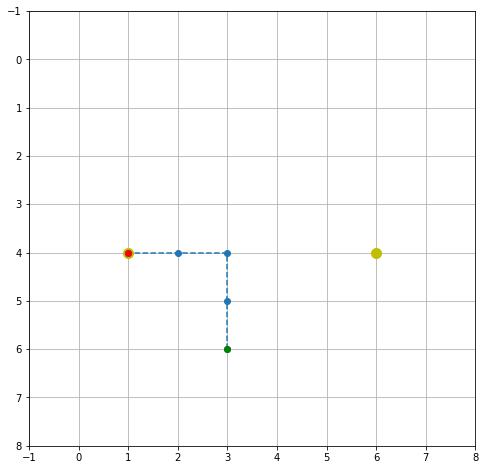

In [464]:
#traj = episode(ag, env, s=[1,3], eps=0.)
traj = episode(ag, ag.venv.envs[0], s=None, eps=0.)
ag.venv.envs[0].draw(traj=traj);

In [219]:
s = ag.venv.envs[0].reset()
print(s)
#env.render()

[5 7]


In [220]:
s = np.array([[5,6]])
Qa = ag.Q(torch.as_tensor(s).float())

In [221]:
Qa

tensor([[6.3182, 5.3722, 6.7821, 7.1567]], grad_fn=<AddmmBackward>)